# Polarization week 0
`Dopo aver classificato, per la settimana di interesse, utenti influenti e non, si procede con il calcolo della polarizzazione`

NB: Soltanto per la prima settimana si usa un notebook che descrive la logica con cui è possibile calcolare la polarizzazione.
Per le altre settimane, essendo il procedimento lo stesso, i notebook non vengono commentati.

***

In [1]:
import numpy as np
import itertools
import collections
import pandas as pd
from scipy.sparse import csr_matrix, coo_matrix

In [2]:
import sys
sys.path.append('../')

In [3]:
from lib import mongoAPI

## Read dataframe (da MongoDB)
Si ottengono tutte le interazioni (retweet) tra un utente influente (chiamato anche "Page") e un utente non influente ("User")

In [4]:
print("Connessione MongoDB...")
mongo_conn = mongoAPI.get_connection("localhost", 27027)
mongo_db = mongo_conn.get_db("dataman_project")
mongo_coll_links = mongo_db.get_collection("links")
print("Done")

Connessione MongoDB...
Done


In [5]:
week = 0
df = mongo_coll_links.read_df_week(week)
del df["week"]
df.head()

,page,user
0,2812961,1205217770171965440
1,2812961,323951434
2,2812961,1227802784
3,2812961,807179503239888896
4,2812961,32499511


## Map users ID and pages ID to sequence (1,len(users))
Anziché gli ID utilizzati da Twitter, si associano, a pagine e utenti, un ID progressivo

In [6]:
mapping_pages = {user:index for index, user in enumerate(set(df["page"]))}
mapping_users = {page:index for index, page in enumerate(set(df["user"]))}
rev_dict_pages = {value:key for key,value in mapping_pages.items()}
rev_dict_users = {value:key for key,value in mapping_users.items()}

In [7]:
df_ = pd.DataFrame()
df_["page"] = df["page"].replace(mapping_pages)
df_["user"] = df["user"].replace(mapping_users)

## Visualizzazione grafo bipartito utenti - pagine

In [8]:
indexes = df_[["user", "page"]].to_numpy()
indexes

array([[ 2353,   830],
       [14905,   830],
       [10448,   830],
       ...,
       [19265,   355],
       [11836,   355],
       [ 2876,   770]])

## Costruzione matrice di proiezione (V,E)
#### V = Pagine
#### E = archi pesati con numeri di utenti condivisi tra le pagine

### 1- Creo dizionario:
* key = id utente
* value = lista pagine con cui ha interagito

In [9]:
user_pages_dict = collections.defaultdict(list)
for tuple_ in indexes:
    if tuple_[1] not in user_pages_dict[tuple_[0]]:
        user_pages_dict[tuple_[0]].append(tuple_[1])

#user_pages_dict

### 2- Lista di tuple:
Se un utente ha interagito con più di una pagina, allora tali pagine "condividono" quello stesso utente.

Genero tutte le permutazioni di 2 elementi estratti dalle pagine (la matrice di proiezione deve essere simmetrica).

In altri termini ogni volta che due pagine A e B condividono un utente genero tupla (A,B), che rappresenta un arco del grafo di proiezione

In [10]:
edges = [pages_index_pair for pages_index in user_pages_dict.values() if len(pages_index) > 1 for pages_index_pair in list(itertools.permutations(pages_index, 2))]
#edges

### 3- Pesi:
Contando le tuple ottengo il numero di utenti che la coppia (A,B) condivide, i.e. il peso dell'arco del grafo di proiezione

In [11]:
edges_weights = collections.Counter(edges)
edges_weights

Counter({(830, 1911): 22,
         (830, 1053): 5,
         (830, 2064): 2,
         (830, 1715): 3,
         (830, 1370): 4,
         (830, 622): 4,
         (830, 508): 3,
         (830, 586): 4,
         (830, 1308): 12,
         (830, 1357): 3,
         (830, 1838): 6,
         (830, 1733): 3,
         (1911, 830): 22,
         (1911, 1053): 15,
         (1911, 2064): 6,
         (1911, 1715): 6,
         (1911, 1370): 3,
         (1911, 622): 7,
         (1911, 508): 6,
         (1911, 586): 4,
         (1911, 1308): 14,
         (1911, 1357): 1,
         (1911, 1838): 4,
         (1911, 1733): 4,
         (1053, 830): 5,
         (1053, 1911): 15,
         (1053, 2064): 8,
         (1053, 1715): 2,
         (1053, 1370): 3,
         (1053, 622): 14,
         (1053, 508): 9,
         (1053, 586): 3,
         (1053, 1308): 26,
         (1053, 1357): 5,
         (1053, 1838): 12,
         (1053, 1733): 7,
         (2064, 830): 2,
         (2064, 1911): 6,
         (2064, 1053): 8,
 

### 4- Matrice di proiezione:
Tenendo conto del volume, memorizzo la matrice in una matrice sparsa, cioè salvo solo gli archi effettivamente presenti, escludendo quelli con peso zero.
Ciò è possibile utilizzando matrici sparse di SciPy

In [12]:
def dict_to_sparse_matrix(dict_graph):
    data = np.array(list(dict_graph.values()))
    A = np.array(list(dict_graph.keys()))
    rows = A.T[1]
    cols = A.T[0]
    B = coo_matrix((data, (rows, cols)), shape=(len(mapping_pages), len(mapping_pages)))
    return csr_matrix(B)

Matrice di proiezione (per rendere l'idea)

In [13]:
P = dict_to_sparse_matrix(edges_weights)
P.toarray()

array([[ 0,  0,  2, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 2,  0,  0, ...,  0, 14, 10],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0, 14, ...,  0,  0,  2],
       [ 0,  0, 10, ...,  0,  2,  0]])

## Community detection

### Si considerano due algoritmi di Community detection:
* Louvain Algorithm
* Label Propagation

In [14]:
from sknetwork.clustering import Louvain, PropagationClustering, modularity 

## Louvain

In [15]:
louvain = Louvain(modularity="dugue")
labels_louvain = louvain.fit_transform(P)

### Valutazione misura di modularità
Si valuta la bontà del clustering attraverso misura di modularità.
SPIEGAZIONE: range valori ecc..

In [16]:
modularity(P, labels_louvain, return_all=True)

(0.4156081850718893, 0.872525529047648, 0.4569173439757587)

### Dimensione clusters

In [17]:
collections.Counter(labels_louvain)

Counter({1: 807,
         0: 994,
         2: 282,
         6: 4,
         4: 15,
         10: 2,
         14: 2,
         45: 1,
         57: 1,
         38: 1,
         24: 1,
         25: 1,
         9: 3,
         5: 4,
         3: 20,
         61: 1,
         85: 1,
         93: 1,
         8: 3,
         102: 1,
         13: 2,
         94: 1,
         95: 1,
         16: 2,
         67: 1,
         81: 1,
         17: 1,
         79: 1,
         7: 4,
         78: 1,
         77: 1,
         76: 1,
         75: 1,
         12: 2,
         74: 1,
         73: 1,
         72: 1,
         80: 1,
         71: 1,
         69: 1,
         68: 1,
         66: 1,
         65: 1,
         64: 1,
         63: 1,
         11: 2,
         62: 1,
         70: 1,
         82: 1,
         92: 1,
         83: 1,
         101: 1,
         100: 1,
         99: 1,
         98: 1,
         97: 1,
         96: 1,
         91: 1,
         103: 1,
         89: 1,
         88: 1,
         87: 1,
      

### Commento:
* Buon valore di modularità
* 3 grandi clusters

## Label Propagation

In [18]:
propagation = PropagationClustering(sort_clusters=True)
labels_propagation = propagation.fit_transform(P)

### Valutazione misura di modularità

In [19]:
modularity(P, labels_propagation, return_all=True)

(0.4024855136767216, 0.9215714826571919, 0.5190859689804703)

### Dimensione clusters

In [20]:
collections.Counter(labels_propagation)

Counter({55: 882,
         67: 1246,
         0: 2,
         1: 2,
         16: 2,
         2: 1,
         3: 1,
         4: 1,
         5: 1,
         6: 1,
         7: 1,
         8: 1,
         9: 1,
         10: 1,
         20: 2,
         11: 1,
         12: 1,
         14: 2,
         13: 1,
         15: 1,
         17: 1,
         18: 1,
         19: 4,
         21: 1,
         22: 1,
         23: 1,
         24: 1,
         25: 2,
         26: 1,
         27: 1,
         28: 1,
         29: 1,
         30: 1,
         34: 2,
         31: 1,
         32: 1,
         33: 1,
         35: 1,
         36: 1,
         37: 1,
         57: 2,
         38: 1,
         39: 1,
         40: 1,
         41: 1,
         42: 1,
         43: 1,
         44: 1,
         45: 1,
         46: 1,
         47: 1,
         48: 1,
         49: 2,
         50: 1,
         51: 1,
         52: 1,
         53: 1,
         54: 1,
         56: 1,
         58: 1,
         59: 1,
         60: 1,
         61: 

### Commento:
* Buon valore di modularità
* 2 grandi clusters

### Osservazioni:
* modularità simili
* si decide di studiare i cluster ottenuti con Louvain

## Validazione manuale (quale cluster è vax e quale non)
Non avendo dati disponibili per una validazione supervisionata si procede manualmente:
Per ogni cluster si estrae un campione di utenti, e studiandone il feed, si decide se essi siano pro-vax, no-vax o neutrali

### Verifichiamo chi sono alcuni di loro con le API di Twitter

In [21]:
import tweepy
#Configurazione e autenticazione
access_token = "1328983562767519750-dF4HK59zfJrtqmnziHoM7eMHuQZN2F"  
access_token_secret = "NwYbWnA5rnxkxQISCuvxRk3wG5YVqwstp3w6Uz4uCp8H2"  
consumer_key = "y3TqPO1ZOOajzhX7Fh0tpc59M"  
consumer_secret = "ll4t1rp3rrHvsYtzONUhpKemaqFtVWWmEQKOODasdyJwajiUsx"  

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

_____________________________________________________________________________________________________________________________________

### Cluster 0

_____________________________________________________________________________________________________________________________________

In [22]:
print(rev_dict_pages[2], labels_louvain[2])

732817452569141248 0


In [23]:
print(api.get_user(732817452569141248).screen_name)

RobertoBurioni


![title](img/burioni.png)

NB. dalla presenza di Burioni nel cluster 0 si può intuire che si tratti di quello dei Pro vax


***

In [24]:
print(rev_dict_pages[33], labels_louvain[33])

2685370465 0


In [25]:
print( api.get_user(2685370465).screen_name)

GiacomoGorini


![title](img/GiacomoGorini.png)

pro vax

_____________________________________________________________________________________________________________________________________

In [26]:
print(rev_dict_pages[29], labels_louvain[29])

2866061393 0


In [27]:
print(api.get_user(2866061393).screen_name)

petronillarusso


![title](img/petronillarusso.png)

pro vax

***


In [28]:
print(rev_dict_pages[1085], labels_louvain[1085])

50253688 0


In [29]:
print(api.get_user(50253688).screen_name)

f_ronchetti


![title](img/f_ronchetti.png)

pro vax

_____________________________________________________________________________________________________________________________________

### Cluster 1

_____________________________________________________________________

In [30]:
print(rev_dict_pages[163], labels_louvain[163])

475234937 1


In [31]:
print(api.get_user(475234937 ).screen_name)

valy_s


![title](img/valy_s.png)

No vax

***

In [32]:
print(rev_dict_pages[483], labels_louvain[483])

864323299 1


In [33]:
print(api.get_user(864323299).screen_name)

SefanoMalaguti


![title](img/SefanoMalaguti.png)

no vax

______________________________________________

In [34]:
print(rev_dict_pages[22], labels_louvain[22])

1360232480 1


In [35]:
print(api.get_user(1360232480).screen_name)

FmMosca


![title](img/FmMosca.png)

no vax

***

In [36]:
print(rev_dict_pages[0], labels_louvain[0])

1024702799215509504 1


In [37]:
print(api.get_user(1024702799215509504).screen_name)

EmpfindsamerS


![title](img/Empfindsamer.png)

no vax

______________________________________________

### Cluster 2

*** 

In [38]:
print(rev_dict_pages[28], labels_louvain[28])

631767111 2


In [39]:
print(api.get_user(631767111).screen_name)

PediciniEu


![title](img/Pedicini.png)

pro vax

***

In [40]:
print(rev_dict_pages[175], labels_louvain[175])

452010658 2


In [41]:
print(api.get_user(452010658 ).screen_name)

serebellardinel


![title](img/sere.png)

Pro/Neutrale

***

In [42]:
print(rev_dict_pages[453], labels_louvain[453])

752010888 2


In [43]:
print(api.get_user(752010888 ).screen_name)

tranellio


![title](img/tranellio.png)

Neutrale

***

In [44]:
print(rev_dict_pages[1283], labels_louvain[1283])

192352800 2


In [45]:
print(api.get_user(192352800).screen_name)

annatrieste


![title](img/annatrieste.png)

Neutrale

***

## Osservazioni:
* 0 -> provax
* 1 -> novax
* 2 -> Difficile da stabilire, anche se osservando il campione osservato si potrebbe concludere siano "neutrali" o comunque "moderati"

# Polarizzazione
## Distribuzione vax - novax
Si sceglie il clustering prodotto da Algoritmo Louvain

In [46]:
page_community_df = pd.DataFrame({"page_id" : rev_dict_pages.values(), "community" : labels_louvain})
page_community_df.head()

,page_id,community
0,1024702799215509504,1
1,701849940809662464,0
2,732817452569141248,0
3,765979700808286208,1
4,1100776937004457984,1


## Conservo solo le pagine dei tre cluster principali

In [47]:
page_community_df = page_community_df[(page_community_df["community"] == 0) | (page_community_df["community"] == 1)| (page_community_df["community"] == 2)]
page_community_df.head()

,page_id,community
0,1024702799215509504,1
1,701849940809662464,0
2,732817452569141248,0
3,765979700808286208,1
4,1100776937004457984,1


## Conto, per ciascun utente, numero di interazioni con ciascuna community

In [48]:
result = pd.merge(df, page_community_df, how="inner", left_on="page", right_on = "page_id")
result.head()

,page,user,page_id,community
0,2812961,1205217770171965440,2812961,0
1,2812961,323951434,2812961,0
2,2812961,1227802784,2812961,0
3,2812961,807179503239888896,2812961,0
4,2812961,32499511,2812961,0


In [49]:
count_interact_community  = result.groupby(["user", "community"]).count().sort_values("page").reset_index()
count_interact_community

,user,community,page,page_id
0,1384633517511004160,1,1,1
1,1227333289,2,1,1
2,1039090056743608320,0,1,1
3,1227463890,1,1,1
4,1227625616,2,1,1
...,...,...,...,...
29260,510786998,0,142,142
29261,3194573930,0,156,156
29262,793367160341094400,0,170,170
29263,971816547898490881,1,181,181


Si osserva che molti utenti interagiscono con tutte e 3 le community, per cui la polarizzazione non è immediata:

In [50]:
tmp = count_interact_community.groupby("user").count().reset_index()
tmp[tmp["community"] > 2][["user", "community"]]

,user,community
402,22064941,3
748,40433343,3
761,40962257,3
811,44558656,3
1071,53400401,3
...,...,...
25684,1356184042820005890,3
25735,1357646535299858432,3
25892,1361833561972686849,3
25984,1364225080859926540,3


In [51]:
del tmp

Ad es. l'utente seguente:

In [52]:
result[result["user"] == 22064941]

,page,user,page_id,community
15012,485586578,22064941,485586578,1
29238,438849246,22064941,438849246,1
34685,414373079,22064941,414373079,0
36380,87467449,22064941,87467449,0
51626,96355801,22064941,96355801,0
60541,22651555,22064941,22651555,2
78564,413916151,22064941,413916151,1
82220,81637419,22064941,81637419,1
82448,81637419,22064941,81637419,1


Per ciascun utente si ricava il numero di interazioni con le community

In [53]:
count_interact_community_pivot = count_interact_community.pivot(index = "user", columns="community", values = "page")
count_interact_community_pivot.fillna(0, inplace = True)
count_interact_community_pivot

community,0,1,2
user,,,
3637,2.0,0.0,0.0
382393,1.0,0.0,0.0
394613,2.0,0.0,0.0
617953,1.0,0.0,0.0
621553,1.0,0.0,0.0
...,...,...,...
1370170942006116362,1.0,0.0,0.0
1370990660564684801,1.0,0.0,0.0
1372236670762901506,0.0,1.0,0.0


## Si considerano solo utenti con almeno 10 interazioni totali

In [54]:
count_interact_community_pivot = count_interact_community_pivot[count_interact_community_pivot[0] + count_interact_community_pivot[1] + count_interact_community_pivot[2] > 10]
count_interact_community_pivot

community,0,1,2
user,,,
8960282,7.0,12.0,0.0
9437162,3.0,19.0,0.0
10282412,29.0,0.0,0.0
11540552,0.0,31.0,0.0
14073125,60.0,5.0,0.0
...,...,...,...
1361301350416580617,1.0,19.0,0.0
1361979348622925824,7.0,4.0,0.0
1362440566785658880,14.0,29.0,0.0


# Costruzione della PDF

In [55]:
def polarization(pos, neg):
    return (pos-neg)/(pos+neg)

In [56]:
def polarization_neutral(pos,neg,neut):
    N = pos+neg+neut
    a = (pos-neg)/(pos+neg)
    return a - a*neut/N

In [57]:
data = polarization_neutral(count_interact_community_pivot[0], count_interact_community_pivot[1], count_interact_community_pivot[2]).to_numpy()
data = np.nan_to_num(data)

## Kernel Density Estimation

In [58]:
from scipy.stats.kde import gaussian_kde
from numpy import linspace
from matplotlib import pyplot as plt
from scipy.signal import find_peaks

kde = gaussian_kde(data)
dist_space = linspace(min(data), max(data), 100)
x = kde(dist_space)
peaks, _ = find_peaks(x, distance=50)

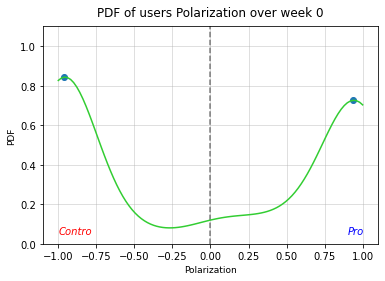

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title(f"PDF of users Polarization over week {week}", pad = 10)
ax.grid(alpha = 0.5)
ax.axvline(0, color = "black", linestyle='--', alpha = 0.5)
ax.plot(dist_space[peaks], x[peaks], "o")
ax.plot(dist_space, x, color = "limegreen")
ax.set_xlabel('Polarization', fontsize=9)
ax.set_ylabel('PDF', fontsize=9)
ax.set_ylim(0,1.1)
ax.text(0.9, 0.05, 'Pro', style='italic', color = "b")
ax.text(-1, 0.05, 'Contro', style='italic', color = "r")
plt.show()

In [60]:
#pd.DataFrame({"x" : dist_space, "y" : x}).to_csv(f"viz/pol_week_{week}.csv")

(array([561., 108.,  29.,  23.,  16.,   9.,   9.,   7.,   6.,   4.,  53.,
         18.,  15.,  24.,  19.,  28.,  28.,  42., 109., 454.]),
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
         0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <BarContainer object of 20 artists>)

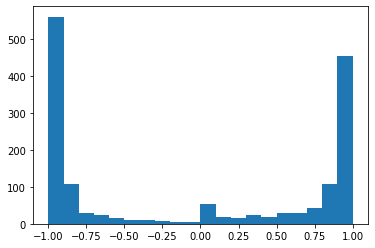

In [61]:
plt.hist(data, bins = 20)

## Osservazioni:
* Distribuzione bimodale

## Test statistico di bimodalità (Dip Test)
H_0 : Distribuzione unimodale

In [62]:
import unidip.dip as dip

data = np.msort(data)
test = dip.diptst(data)
print(test) #dip, pvalue, indices

(0.14889031156636795, 0.000999000999000999, (0, 93))


Si rifiuta ipotesi nulla di unimodalità con confidenza del 1 %

## Bimodality Coeff

In [63]:
from scipy.stats import kurtosis, skew
def bimodality_coeff(distr):
    g = skew(distr)
    k = kurtosis(distr)
    n = len(distr)
    return (g**2 + 1) / (k + 3*(n-1)**2/((n-2)*(n-3)))

In [64]:
bc = bimodality_coeff(data)
bc

0.8664743643525591

In [65]:
def bimodality_ratio(a,b):
    return a/b if a < b else b/a

In [66]:
bimodal_ratio = bimodality_ratio(*list(x[peaks]))
bimodal_ratio

0.8610103942219418

In [67]:
bc*bimodal_ratio

0.7460434340344033